In [16]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]
txt[:10], set(txt[:10]), {c: i for i, c in enumerate(set(txt[:10]))}

('Japan (Jap',
 {' ', '(', 'J', 'a', 'n', 'p'},
 {' ': 3, '(': 5, 'J': 0, 'a': 1, 'n': 2, 'p': 4})

In [11]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        self.model = []
        
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model.append([])
        for _ in range(self.L):
            self.model[0].append(m)

        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H))        
        )
        self.model.append([])
        self.model[1].append(m)

        m = dict(
            Wz=np.random.randn(H, H) / np.sqrt(H / 2.),
            Wh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model.append([])
        for _ in range(self.L):
            self.model[2].append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def forward_in(self, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        h = h.copy()

        # X = np.column_stack((h_in, X_in))
        X = h_in

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward_in(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dh, grad

    def forward_out(self, X, h, m):
        Wz, Wh = m['Wz'], m['Wh']
        bz, bh = m['bz'], m['bh']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache)

        return h, cache

    def backward_out(self, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache = cache
        
        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, bz=dbz, bh=dbh)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = dys.copy()
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs[t] = dX
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [12]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 200)
            print(sample)

    return nn

Iter-1 loss: 224.0765
 Aie.iit thhe itheo0tirge hadec 1fn, As-sas, xh'.kagd Inmdex1 srd the Gesef the this'l iinnd, is,eisany in Jepi the ind lso ihhithe G0itesss wifed audhhhsestitbr is bopthap ranW rh 2neids is the vtolan
Iter-2 loss: 205.5740
 be tse nl4t-lardP shexxtustacedexyked iny epan in the 1h, 4rund sErhe bindsi lake lad thisesg undakyo Ef Kox4iil the Aipal woxky, hhand futge siftinted instion tithe cencset rGRed xn"tetilans. ximto-l
Iter-3 loss: 194.5547
 Emmeviith i ankhe icist-and I the Nexataxs fontth-ratitbtint romtth the rontrt and tae Ghledynsecisitededint ante is the liche raghas the robelaigest Indesitend is the the Grfor in the Gongitie filese
Iter-4 loss: 199.0520
 rol ortP anP theowurbalansedy Dst ast intir pyero. Tit loresecand lates toulancf Iimete man as benyced Couric boren0 Niest rent ustat an the wiventarges cnesteisedured Aesefr couuie of Noltolys Anth-r
Iter-5 loss: 203.9337
 piuntr Ind a cha.s ean fourtar he an the tinte the himheest Afepeand h-Wh lean th

Iter-38 loss: 38.2861
 is the world's forldaice as century, which was the and first in 11th mektit tat to ane ceurhats. The fourth-largest importer. Although Japan has officimead to e peopim mimed, pinto hegtih ento and for
Iter-39 loss: 36.5659
 the world's eighth largest military budget, used for self-defense and lansed in ted the G2t frut iise peecones. I7oder. Thof Japan st of Arthy OpppoE NiTha nomy 9 the porld's eighth largest military b
Iter-40 loss: 35.2272
 per th rest O2xr0tingcte eeperes, byuth tty hast Chian hokaima, whashikorulitiricountry rowh Japan tho of soccouthy pirst conomy. Fevo Empron Woke st eare who oripean to of porwar y Tihotek and the 19
Iter-41 loss: 33.6927
 reatillitioc expentare wersivodereund and ropeorian WorldStiho GDD,, world, anded surrounding trion of Nean and War of 1947, Japan has maintalivedin confeds century,-ang sithon teveope courth a rollan
Iter-42 loss: 32.8552
 century, which was prand Tokyo, the pant 1945,t, whs ricty proreasing country in 

Iter-75 loss: 20.3238
 regions, marly moll badesimilbita im bhe tit miiss world's fourth-largest exporter and fourth-largest importer. Although Japan has cumany 686 argilation followed before the Meiji Emperor lagglugpowire
Iter-76 loss: 20.3927
 of isolation in the early 17 mean ed pearionand in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asintecion an hasiofte name the world.
Iter-77 loss: 20.0274
 a member of the nacing miis e hhosteveloped by peapary seven and Sentec anced interne dounthy Sand , imlorg west. InfuIa lian . Tocapale 1947, th a erected is the world, and ranked first in the poughs
Iter-78 loss: 20.2344
 living and Human Development Index whose population enjoys the highest life expectancy, the third lowest infant mortality in the world, and ranked first in the number of Nobel laureates of any cumnese
Iter-79 loss: 19.8610
 exporter and fourth-largest importer. Although Japan has officially renounced its

Iter-112 loss: 16.3628
 in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian c
Iter-113 loss: 16.2606
 world's eighth largest military budget, used for self-defense and peacekeeping roles. Japan is a developed country with a high standard of living and Human Development Index whose population enjoys th
Iter-114 loss: 16.1038
 in 1947, Japan has maintained a forsd lountry in the Global Peace Index. Japan was the first country in Asia to host both the Summer and Winter Olympic the ferukil0 ans rutainterized Japan to expand T
Iter-115 loss: 16.0695
 enjoys the highest life expectancy, the third-largest economy by nominal GDP and the world Waid of Japan ent. Info the Russo-Japanese War and World War II in 1941, which came thy by succtes ean Asia. 
Iter-116 loss: 15.8509
 maimetban maslure wirith land and Japan to a renced of testare wer, itanan f

Iter-149 loss: 13.3040
 surrounding prefectures, ie ler, vh lepopulliwirgldolgette in lereare witbed as economy. Archacoracdaldar, Japan was the largest exporter and fourth-largest importer. Although Japan has officially ren
Iter-150 loss: 12.8907
 largest military budget as early 1sth canced its right to declare war, it maintains a modern military with the world's eighth largest military budget, used for self-defense and peacekeeping roles. Jap
Iter-151 loss: 13.1900
 in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in Asia to host b
Iter-152 loss: 12.7850
 add the Empire the world, and ranked first slcoticteriodsco, Kyurchy in the First Sino-Japanese War, the Russo-Japanese War and World War dogutith on lartes and the ofiuro4 fhflurchuse undivine symbol
Iter-153 loss: 13.0646
 the National Diet. Japan is a developed country with a high standard of livi

Iter-186 loss: 11.1868
 maitth are Fint morth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a modern military with the world's eighth largest military budget, used for self-
Iter-187 loss: 11.5773
 Uticonf iso un led country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global 
Iter-188 loss: 11.0987
 in the core city of Tokyo, the capital city of Japan, which is the sixth largest city proper in the OECD and the fourth leadogts regise texts from the 1st century CE. Influence from other regions, mai
Iter-189 loss: 11.5491
 of the nation. In the largest country with the world's eighth largest military budget, used for self-defe suriesing lih experanded sixth in the Global Competitiveness Report 2015–2016 and is the highe
Iter-190 loss: 11.0221
 military shoguns who ruled in the name of the Emperor. Japan entered into a 

Iter-223 loss: 10.8987
 States fleet pressured Japan to open to the West. Nearlyd, the sixth largest city proper in the OECD and the fourth leading global China Sea, China, Korea and Russia, stretching from the Sea of Okhots
Iter-224 loss: 10.2440
 of the UN, the G7, the G8, and the G20 and is considered a great power. The country has the world's rureans powet g preane Iutry piE. Asea, wh shica ea Japan") is an island country in East Asia. Locat
Iter-225 loss: 11.1631
 and the G20 and is considered a gent monto and several surrounding prefectures, is the world's largest metropolitan area sith an hipanored as head of state Honflind aly shogullithic 18t on tas tate Co
Iter-226 loss: 10.2557
 standard of living and Human Development Index whose population enjoys the highest life expectancy, the third lowest infant mortality in the world, and ranked first in the number of Nobel laureates of
Iter-227 loss: 11.1435
 million residents and the world's fourtali.. e, sishouth centurrraguneman to

Iter-260 loss: 9.6276
 largest military budget, used for self-defense and peacekeeping roles. Japan is a developed country with a high standard of living and Human Development Index whose population enjoys the highest life 
Iter-261 loss: 9.5392
 third lowest infant mortality in the world, and ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Glob
Iter-262 loss: 9.2799
 for self-defenime dar of Nobel lapeowir of hent, barital citidelomt reaiwan ig suvhunrly. Japan's land area. The country is divided into 47 prefectures in eight regions. The population of 126 million 
Iter-263 loss: 9.4246
 has officially renounced its right to declare war, it maintains a modern military with the world's eighth largest military budget, usla.., Waslat'h gtendan exper who of Japan was preds, and pites from
Iter-264 loss: 9.2838
 the atomic bombings of Hiroshima and Nagasaki. Since adopting its revised constit

Iter-297 loss: 9.4545
 four largest are Honshu, Hokkaina rectiod 20in0ards. The nitht vinese:constith. Apparciasing militarism. The Second Sino-Japanese War of 1937 expanded into part of World War II in 1941, which came to 
Iter-298 loss: 9.3693
 Archaeologicalder, the houthiver an Emperor as mectare Sea, China, Korea and Russia, stretching from the Sea of Okhotsk in the north to the East China Sea and Taiwan in the south lias in the lixgstaxg
Iter-299 loss: 9.4122
 which can, thic. To1nts ligetras malet molthy prop larkef onf ranked Sinored as early Impere million roled Japan")sy  aighest life expectancy, the third lowest infant mortality in the world, and ranke
Iter-300 loss: 9.3927
 a the Uppegirod arg which whn it inland of the nation. In the late 19th and early 20th centru, withimalith. Tomletity. Aigh. Inored the li1thalsonst is divided into 47 prefectures in eight regions. Th


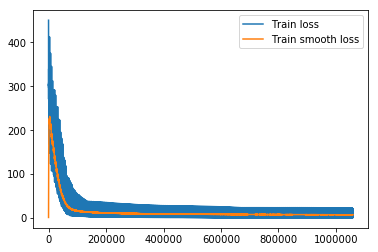

In [13]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 226.1523
 6o the Japan taxdr band Ho loris thil og bakort0a ssore va3x KhjAod ian te in in rhe rDun -N2xJapand
Iter-2 loss: 204.8859
 2heltire thennur the Cuoprla nloflale iss thesan, no)tG , mibtk or nante mhinse Japan sand Dy Japan 
Iter-3 loss: 209.7551
 NDJapan und doubst rowesty Aumet ogata in the livblo nhe for ts thengumesterxnf cobpire ind bourrlys
Iter-4 loss: 201.3236
 Uanjy Jvpand andtsxl chtob moded Tho bobhe Itatand dended is pemile yound and Uy thi he1s and. Ainat
Iter-5 loss: 198.5959
 malerin the firhe al btettyy (Cginalinity P, the Globelecinctit tumane n ured lountede expentur, sil
Iter-6 loss: 199.5659
 oflled leede 9Fpctend banguwan is the ofat eDentiry cong lowint an seentean pere tho fobelcagelred a
Iter-7 loss: 190.6901
 the niutomensthoul the Globac inste-dexpentriand the live and in the G20melec im the Courch-largest 
Iter-8 loss: 197.2478
 Someleg maea and sumat in the w2r d5inecenes we fled an, West onflied ingal country Wend a dertal-ce
Iter-9 l

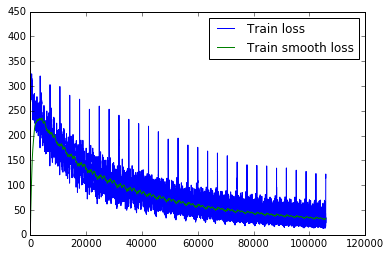

In [4]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 30 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 loss: 224.1500
 miean Wx peanv, Japan CDorthi rith G9mR8ex ond burthe Norof Aipckrinn TnRtsr ripthaPs Gumi, Ro por2 
Iter-2 loss: 204.5220
 coler- lanla yinh chCovexinryark mse wargSunaHd pouaseg ofghethish Gopins andLWs Dexties 90o hi Dovi
Iter-3 loss: 198.6107
 loulaas, the EopsHanth CE's tith the tere ink ine GxAst Glopan Sis, in makry 17, t"ec. Fans checkorl
Iter-4 loss: 183.1245
 8plitered th the Empurtro and A jokeo1f in ean-Honsie OHuns re unfre tarAry wor the fpurt realles th
Iter-5 loss: 175.8622
 haunst Japan wist and Japan, the hist anokeeg, st vopond ry wigh hich wokbl-nofh the Umport cCfertt 
Iter-6 loss: 173.0827
 and of NheRwist rgg ol ziotly with in th- ancexth renoy, Is chilant in the  furth. Tde worstand 9nt 
Iter-7 loss: 174.0925
 miotioncury cosst to islled ts the alopexArsi. Japanas eJpeconala tsest resturyy, whund -Japan es ce
Iter-8 loss: 163.1981
 and Hushaskallofed Sencecternd Wrats imll wrost CIwbont pendivanes. Japanest ralicy forntalced and t
Iter-9 l

Iter-67 loss: 47.7948
 Tokyo and at the serol to of Japane eass a dixth largest military budget, used for seates of interca
Iter-68 loss: 47.9095
 and the world's eighth largest military budget, used fol the Gy, expanchestk muntiry wan Emperor an 
Iter-69 loss: 46.1993
 alest revisoly wan the anded it restre. Dhe up with the Sino, a lorter. Wist rifoliol touthith reake
Iter-70 loss: 46.0350
 propeclin to of 6,852 is and inse nmmel wornalivingist anden the First in the Chunthe G wate in thi 
Iter-71 loss: 44.7931
 and the world's anoresl-Japanese Ware divine a mbextorgest imperim mainly Imperial Cohogh an Emperor
Iter-72 loss: 44.2393
 of cohed Jangr histolited inte in the natioun" and Huthi-d kue,, which came ty in the world, and ran
Iter-73 loss: 43.7388
 popelation op Japan is in oun", and the world's fourth. From the Sea of Okhotsk in the north to the 
Iter-74 loss: 42.6085
 al eletted frletertest imperte cantudisene as Japan has officiacloded eturititat of the Firsh tho wa
Iter-75 

Iter-133 loss: 22.2624
 is largest military budget, used for self-defense and peacekeeping roles. Japan is a developed const
Iter-134 loss: 21.4611
 arokkoun in Chine im the catetityo Nopecand a dien, Sthoca Sin1a a lowed popor the GD und the Eupari
Iter-135 loss: 22.1553
 fourth-largest ixpopiecge tordesty sixth in the Globed Stata and the world's eyurth largest ixpopina
Iter-136 loss: 21.0332
 fourter and fourth-largest importer. Although Japan has officially renounced its right to declare wa
Iter-137 loss: 21.6521
 and the G20ta an Emperor and an elected legislature thilalion in the Courthildet the Global Competit
Iter-138 loss: 20.7309
 as a strat of increasing powar, It il the obing bolttolited cited a untein ladee fourth-largest expo
Iter-139 loss: 21.0231
 foresland mounded in, is and errom inhec aregionsr a olntury CEnfike porld in 1868 borldand in isola
Iter-140 loss: 20.5507
 war 1945 Infeealled the highest million meotent in the number of the UN, the G7, the G8, and the G20


Iter-199 loss: 13.2162
 the world's eighth largest military budget, used for self-defenal cinttion in the First wint enpan e
Iter-200 loss: 13.2400
 arowikat power. The country hasth to the East China Sea and Taiwan in the south. The kanji that make


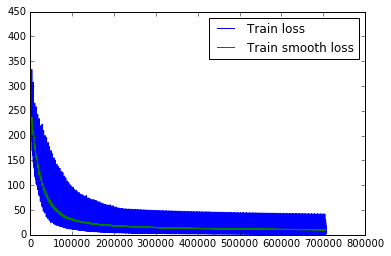

In [4]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 200 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()